In [12]:
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Load cleaned_data from the file
with open("cleaned_df.pkl", "rb") as file:
    df = pickle.load(file)

# Use cleaned_data in scale.ipynb
df.head()


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,2019-04-04 12:01:00,770.0,2019-04-25 14:35:00,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,2019-04-09 13:04:00,235.0,2019-04-25 08:15:00,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,2019-04-09 17:42:00,1.0,2019-04-25 11:58:00,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,2019-04-10 00:31:00,486.0,2019-04-25 07:36:00,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,2019-04-12 20:10:00,565.0,2019-04-25 10:40:00,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [19]:
# Aggregate engagement metrics per customer
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',                    # Session frequency
    'Dur. (ms)': 'sum',                      # Total duration
    'Total DL (Bytes)': 'sum',               # Total download
    'Total UL (Bytes)': 'sum'                # Total upload
})

# Add a total traffic column
engagement_metrics['Total Traffic (Bytes)'] = engagement_metrics['Total DL (Bytes)'] + engagement_metrics['Total UL (Bytes)']
engagement_metrics.rename(columns={
    'Bearer Id': 'Session Frequency',
    'Dur. (ms)': 'Total Duration (ms)'
}, inplace=True)

# Top 10 customers per engagement metric
top_customers_frequency = engagement_metrics.sort_values(by='Session Frequency', ascending=False).head(10)
top_customers_duration = engagement_metrics.sort_values(by='Total Duration (ms)', ascending=False).head(10)
top_customers_traffic = engagement_metrics.sort_values(by='Total Traffic (Bytes)', ascending=False).head(10)

# Display results
top_customers_frequency, top_customers_duration, top_customers_traffic


(               Session Frequency  Total Duration (ms)  Total DL (Bytes)  \
 MSISDN/Number                                                             
 0.000000e+00                1066           72446396.0      4.869236e+11   
 3.362632e+10                  18            8791927.0      7.301517e+09   
 3.362578e+10                  17           18553754.0      7.770043e+09   
 3.361489e+10                  17            9966898.0      8.156743e+09   
 3.365973e+10                  16            4035428.0      7.081602e+09   
 3.376054e+10                  15            9279434.0      7.811295e+09   
 3.367588e+10                  15            4865947.0      7.309542e+09   
 3.366716e+10                  13            8744914.0      5.052068e+09   
 3.362708e+10                  12            4703516.0      5.309479e+09   
 3.360313e+10                  12            6287761.0      4.540607e+09   
 
                Total UL (Bytes)  Total Traffic (Bytes)  
 MSISDN/Number              

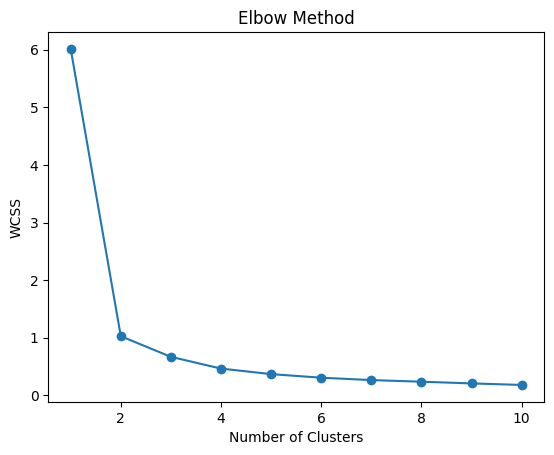

Session Frequency                            Total Duration (ms)  \
                      min   max         mean     sum                 min   
Cluster                                                                    
0                       1     4     1.220531  119158              7142.0   
1                    1066  1066  1066.000000    1066          72446396.0   
2                       1    18     3.226810   29777             85554.0   

                                                Total Traffic (Bytes)  \
                max          mean           sum                   min   
Cluster                                                                 
0          466021.0  1.134458e+05  1.107549e+10          3.324901e+07   
1        72446396.0  7.244640e+07  7.244640e+07          5.312489e+11   
2        18553754.0  4.923438e+05  4.543349e+09          5.714004e+07   

                                                   
                  max          mean           sum  
Cluster                                            
0        2.439177e+09  5.989573e+08  5.847500e+13  
1        5.312489e+11  5.312489e+11  5.312489e+11  
2        8.846226e+09  1.664331e+09  1.535844e+13

In [20]:
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics)

# Elbow method to determine optimal k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# From the plot, choose optimal k (e.g., k=3)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
engagement_metrics['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Compute cluster stats
cluster_stats = engagement_metrics.groupby('Cluster').agg({
    'Session Frequency': ['min', 'max', 'mean', 'sum'],
    'Total Duration (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Traffic (Bytes)': ['min', 'max', 'mean', 'sum']
})

cluster_stats

In [21]:
# Aggregate traffic per application
application_traffic = df.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum', 
    'Social Media UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum'
})

# Calculate total traffic per application
application_traffic['Social Media Traffic'] = application_traffic['Social Media DL (Bytes)'] + application_traffic['Social Media UL (Bytes)']
application_traffic['YouTube Traffic'] = application_traffic['Youtube DL (Bytes)'] + application_traffic['Youtube UL (Bytes)']
application_traffic['Netflix Traffic'] = application_traffic['Netflix DL (Bytes)'] + application_traffic['Netflix UL (Bytes)']

# Identify top 10 most engaged users per application
top_social_media_users = application_traffic.sort_values(by='Social Media Traffic', ascending=False).head(10)
top_youtube_users = application_traffic.sort_values(by='YouTube Traffic', ascending=False).head(10)
top_netflix_users = application_traffic.sort_values(by='Netflix Traffic', ascending=False).head(10)

# Display results
top_social_media_users, top_youtube_users, top_netflix_users


(               Social Media DL (Bytes)  Social Media UL (Bytes)  \
 MSISDN/Number                                                     
 0.000000e+00              1.937715e+09             3.610230e+07   
 3.362632e+10              4.274384e+07             6.309420e+05   
 3.376054e+10              3.929765e+07             4.855430e+05   
 3.365973e+10              3.490044e+07             5.119140e+05   
 3.361489e+10              2.774974e+07             5.448000e+05   
 3.362578e+10              2.656412e+07             5.713790e+05   
 3.366716e+10              2.375375e+07             4.940970e+05   
 3.378632e+10              2.356866e+07             4.062640e+05   
 3.366907e+10              2.347705e+07             3.237870e+05   
 3.360313e+10              2.277668e+07             3.011460e+05   
 
                Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
 MSISDN/Number                                                               
 0.000000e+00         1.24

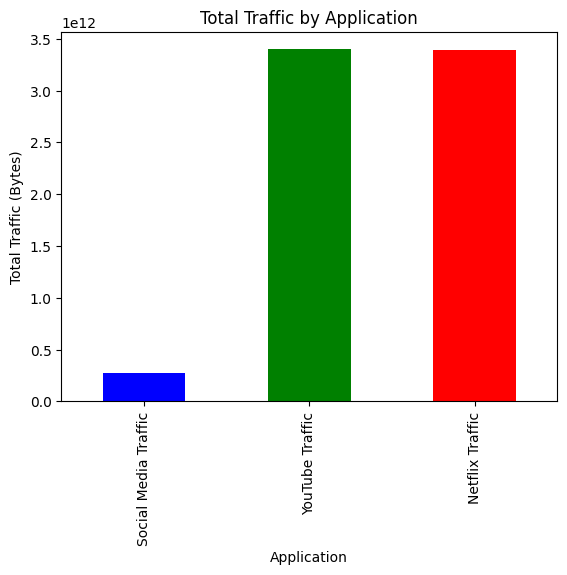

In [22]:
# Aggregate total traffic per application
total_application_traffic = application_traffic[['Social Media Traffic', 'YouTube Traffic', 'Netflix Traffic']].sum()

# Plot traffic for the top 3 applications
total_application_traffic.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Total Traffic by Application')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.show()


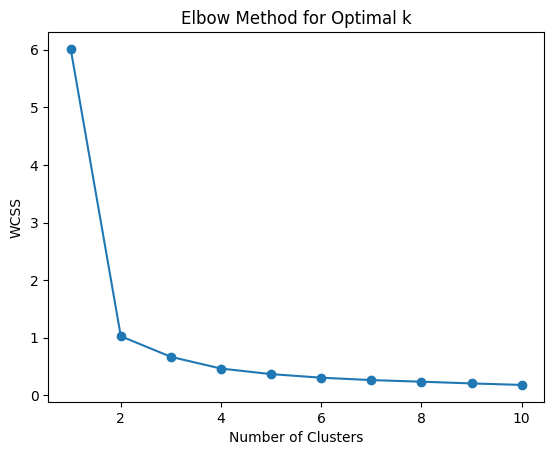

,Session Frequency,Total Duration (ms),Total DL (Bytes),Total UL (Bytes),Total Traffic (Bytes)
Cluster,,,,,
0,1.220531,1.134458e+05,5.488162e+08,5.014111e+07,5.989573e+08
1,1066.000000,7.244640e+07,4.869236e+11,4.432530e+10,5.312489e+11
2,3.226810,4.923438e+05,1.531184e+09,1.331469e+08,1.664331e+09


In [23]:
# Reuse normalized_metrics for clustering
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Optimal k determined from elbow plot
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
engagement_metrics['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Display cluster characteristics
cluster_characteristics = engagement_metrics.groupby('Cluster').mean()
cluster_characteristics
